In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats as stats
import seaborn as sns
import pandas as pd

from scipy import stats
# logistic (or inverse-logit) is the inverse of the logit function
from scipy.special import expit as logistic

import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

from causalgraphicalmodels import CausalGraphicalModel
import daft

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


This is based on the [homework of week 8](https://github.com/rmcelreath/statrethinking_winter2019/blob/master/homework/week08.pdf) of Statistical Rethinking book material.
I do the homework based on the questions but not following a specific order.
<br>
<br>
The dataset can be found [here](https://github.com/rmcelreath/rethinking/blob/Experimental/data/)
<br>

In [2]:
df = pd.read_csv('../data/reedfrogs.csv', sep=';')

# transforming pred and size into categorical variables
# pred_id: 0 (no); 1 (pred)
# size_id: 0 (small); 1 (big)
df['pred_id'] = (df['pred'] == 'pred').astype(int)
df['size_id'] = (df['size'] == 'big').astype(int)


df['pond'] = df.index
df

density  pred   size  surv  propsurv  pred_id  size_id  pond
0        10    no    big     9  0.900000        0        1     0
1        10    no    big    10  1.000000        0        1     1
2        10    no    big     7  0.700000        0        1     2
3        10    no    big    10  1.000000        0        1     3
4        10    no  small     9  0.900000        0        0     4
5        10    no  small     9  0.900000        0        0     5
6        10    no  small    10  1.000000        0        0     6
7        10    no  small     9  0.900000        0        0     7
8        10  pred    big     4  0.400000        1        1     8
9        10  pred    big     9  0.900000        1        1     9
10       10  pred    big     7  0.700000        1        1    10
11       10  pred    big     6  0.600000        1        1    11
12       10  pred  small     7  0.700000        1        0    12
13       10  pred  small     5  0.500000        1        0    13
14       10  pred  small     9  0.900000        1        0    14
15       10  pred  small     9  0.900000        1        0    15
16       25    no    big    24  0.960000        0        1    16
17       25    no    big    23  0.920000        0        1    17
18       25    no    big    22  0.880000        0        1    18
19       25    no    big    25  1.000000        0        1    19
20       25    no  small    23  0.920000        0        0    20
21       25    no  small    23  0.920000        0        0    21
22       25    no  small    23  0.920000        0        0    22
23       25    no  small    21  0.840000        0        0    23
24       25  pred    big     6  0.240000        1        1    24
25       25  pred    big    13  0.520000        1        1    25
26       25  pred    big     4  0.160000        1        1    26
27       25  pred    big     9  0.360000        1        1    27
28       25  pred  small    13  0.520000        1        0    28
29       25  pred  small    20  0.800000        1        0    29
30       25  pred  small     8  0.320000        1        0    30
31       25  pred  small    10  0.400000        1        0    31
32       35    no    big    34  0.971429        0        1    32
33       35    no    big    33  0.942857        0        1    33
34       35    no    big    33  0.942857        0        1    34
35       35    no    big    31  0.885714        0        1    35
36       35    no  small    31  0.885714        0        0    36
37       35    no  small    35  1.000000        0        0    37
38       35    no  small    33  0.942857        0        0    38
39       35    no  small    32  0.914286        0        0    39
40       35  pred    big     4  0.114286        1        1    40
41       35  pred    big    12  0.342857        1        1    41
42       35  pred    big    13  0.371429        1        1    42
43       35  pred    big    14  0.400000        1        1    43
44       35  pred  small    22  0.628571        1        0    44
45       35  pred  small    12  0.342857        1        0    45
46       35  pred  small    31  0.885714        1        0    46
47       35  pred  small    17  0.485714        1        0    47

For some of the models bellow, the MCMC sampling returned warnings like: 
<br>
*'There were 273 divergences after tuning. Increase target_accept or reparameterize.'*
<br>
<br>
This is an example of **Divergent transitions**. The best way to handle it is to reparametrize which means to transform a centered model into a non-centered as follows:
<br>
$ \alpha \sim \mathcal{N}(\mu,\,\sigma)$
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **Centered**
<br>
<br>
is mathematically identical to:
<br>
$ \alpha = \mu + z\sigma$<br>
$ z \sim \mathcal{N}(0,1)$
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; **Non-centered**
<br>
<br>
Centered means that there're parameters inside the distribution. The non-centered form, even though mathematically identical to the centered one, makes Markov Chain more efficient for its inner workings this is a different geometry.

## Model with ponds predictors

In [3]:
with pm.Model() as m1:
    # prior for average pond
    a_bar = pm.Normal('a_bar', 0, 1.5)
    
    # prior for std of ponds
    sigma = pm.Exponential('sigma', 1)
    
    # adaptive prior
    a_pond = pm.Normal('a_pond', a_bar, sigma, shape=len(df.pond))
    
    # log-odds for each pond
    p = pm.math.invlogit(a_pond[df.pond])
    
    # likelihood
    Si = pm.Binomial('Si', n=df.density, p=p, observed=df.surv)
    
    # posterior
    m1_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a_pond, sigma, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/plots/traceplot.py:191: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (50), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'a_bar'}>,
        <AxesSubplot:title={'center':'a_bar'}>],
       [<AxesSubplot:title={'center':'a_pond\n0'}>,
        <AxesSubplot:title={'center':'a_pond\n0'}>],
       [<AxesSubplot:title={'center':'a_pond\n1'}>,
        <AxesSubplot:title={'center':'a_pond\n1'}>],
       [<AxesSubplot:title={'center':'a_pond\n2'}>,
        <AxesSubplot:title={'center':'a_pond\n2'}>],
       [<AxesSubplot:title={'center':'a_pond\n3'}>,
        <AxesSubplot:title={'center':'a_pond\n3'}>],
       [<AxesSubplot:title={'center':'a_pond\n4'}>,
        <AxesSubplot:title={'center':'a_pond\n4'}>],
       [<AxesSubplot:title={'center':'a_pond\n5'}>,
        <AxesSubplot:title={'center':'a_pond\n5'}>],
       [<AxesSubplot:title={'center':'a_pond\n6'}>,
        <AxesSubplot:title={'center':'a_pond\n6'}>],
       [<AxesSubplot:title={'center':'a_pond\n7'}>,
        <AxesSubplot:title={'center':'a_pond\n7'}>],
       [<AxesSubplot:title={'center':'a_pond\n8'}>,
        <Ax

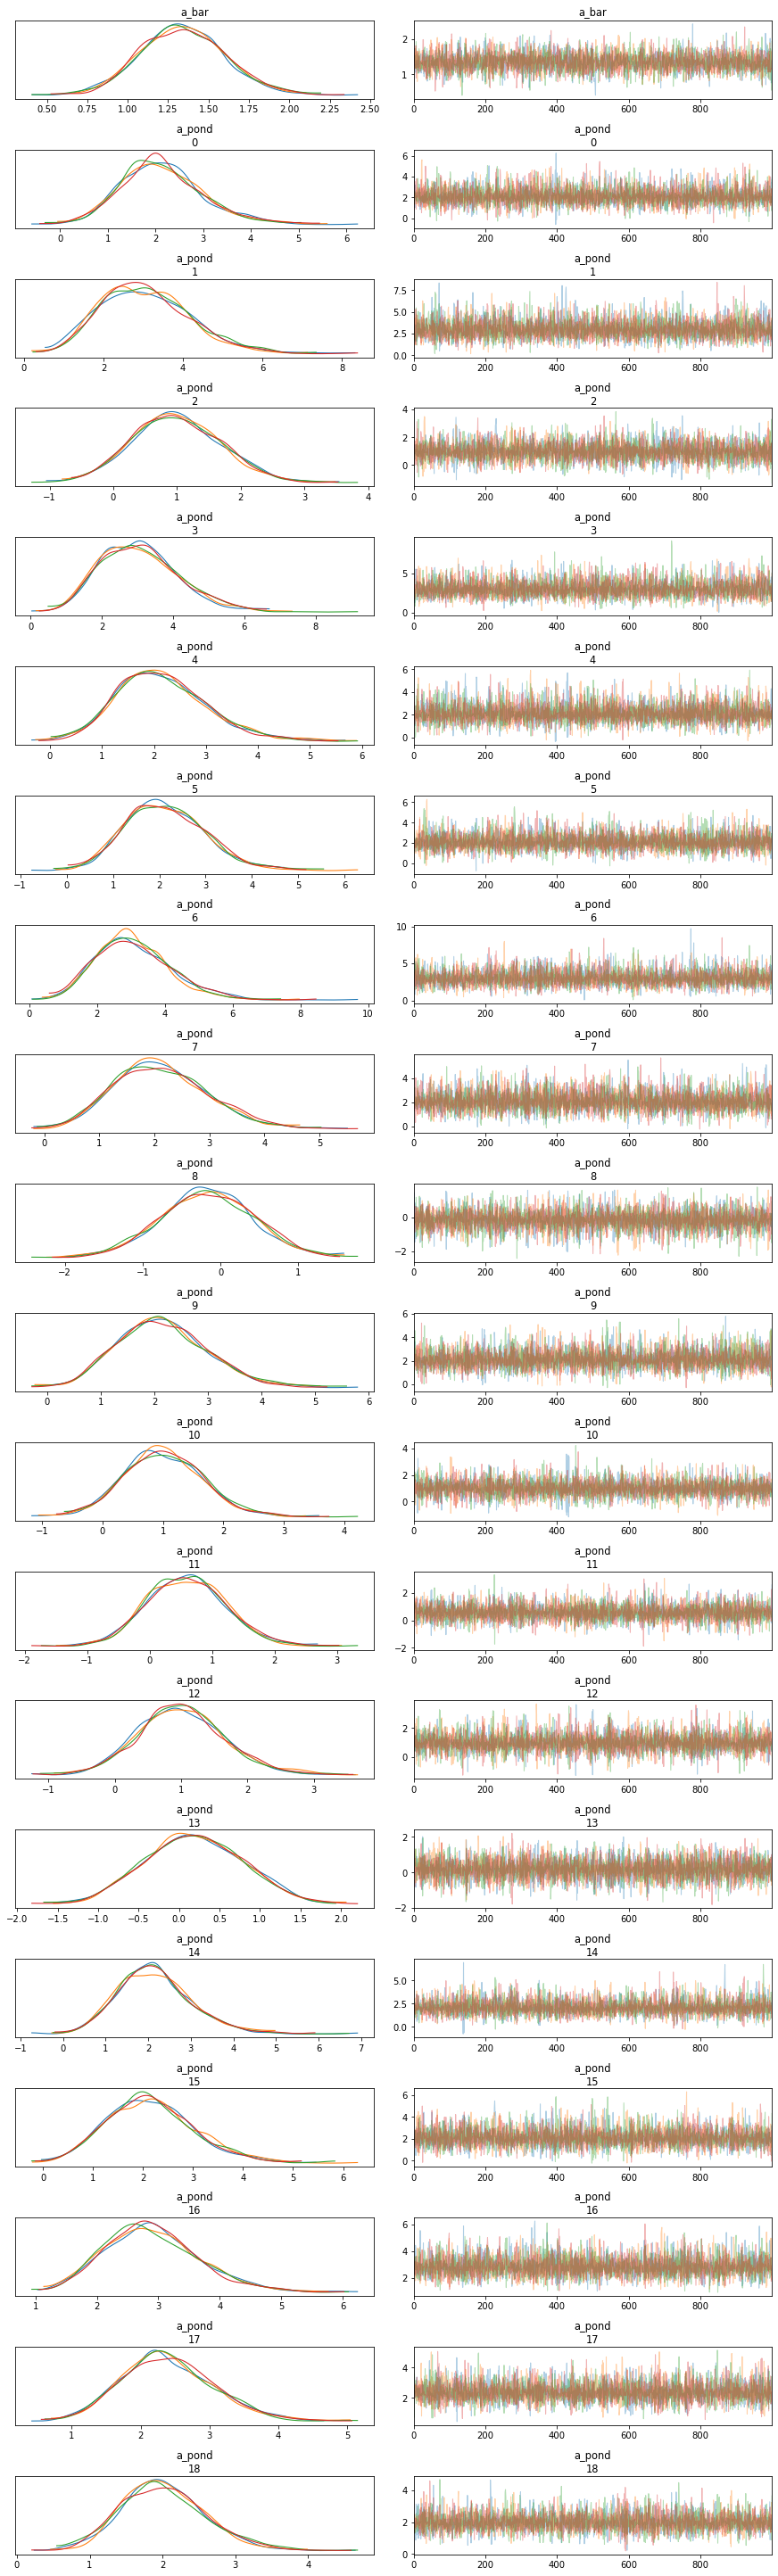

In [4]:
az.plot_trace(m1_trace)

In [5]:
az.summary(m1_trace, kind='stats', round_to=2)

mean    sd  hdi_3%  hdi_97%
a_bar       1.34  0.26    0.84     1.82
a_pond[0]   2.14  0.86    0.69     3.94
a_pond[1]   3.06  1.13    1.05     5.12
a_pond[2]   1.00  0.70   -0.27     2.33
a_pond[3]   3.07  1.12    1.16     5.19
a_pond[4]   2.16  0.89    0.55     3.85
a_pond[5]   2.13  0.87    0.59     3.74
a_pond[6]   3.06  1.10    1.13     5.21
a_pond[7]   2.12  0.85    0.62     3.71
a_pond[8]  -0.17  0.62   -1.32     1.02
a_pond[9]   2.16  0.85    0.64     3.72
a_pond[10]  1.01  0.66   -0.28     2.18
a_pond[11]  0.59  0.62   -0.51     1.78
a_pond[12]  1.01  0.68   -0.25     2.27
a_pond[13]  0.19  0.60   -0.97     1.26
a_pond[14]  2.15  0.87    0.63     3.82
a_pond[15]  2.15  0.88    0.52     3.80
a_pond[16]  2.89  0.77    1.45     4.29
a_pond[17]  2.40  0.68    1.19     3.69
a_pond[18]  2.02  0.58    0.99     3.18
a_pond[19]  3.64  0.99    1.91     5.51
a_pond[20]  2.40  0.67    1.19     3.67
a_pond[21]  2.38  0.64    1.24     3.60
a_pond[22]  2.39  0.65    1.23     3.59
a_pond[23]  1.70  0.54    0.75     2.70
a_pond[24] -1.00  0.44   -1.82    -0.15
a_pond[25]  0.16  0.40   -0.55     0.95
a_pond[26] -1.43  0.51   -2.40    -0.51
a_pond[27] -0.48  0.42   -1.25     0.31
a_pond[28]  0.16  0.40   -0.61     0.88
a_pond[29]  1.43  0.49    0.53     2.34
a_pond[30] -0.63  0.41   -1.43     0.08
a_pond[31] -0.30  0.39   -1.02     0.42
a_pond[32]  3.18  0.75    1.86     4.59
a_pond[33]  2.70  0.66    1.49     3.95
a_pond[34]  2.69  0.64    1.59     3.90
a_pond[35]  2.06  0.51    1.16     3.05
a_pond[36]  2.05  0.50    1.13     2.99
a_pond[37]  3.89  0.95    2.23     5.66
a_pond[38]  2.71  0.64    1.60     3.97
a_pond[39]  2.35  0.57    1.32     3.46
a_pond[40] -1.81  0.46   -2.74    -1.01
a_pond[41] -0.57  0.34   -1.21     0.07
a_pond[42] -0.45  0.34   -1.09     0.21
a_pond[43] -0.33  0.34   -0.99     0.28
a_pond[44]  0.58  0.35   -0.11     1.20
a_pond[45] -0.57  0.34   -1.20     0.04
a_pond[46]  2.06  0.51    1.11     2.99
a_pond[47]  0.02  0.35   -0.69     0.63
sigma       1.61  0.21    1.20     1.99

## Model with ponds + predation predictors

In [6]:
with pm.Model() as m2:
    a_bar = pm.Normal('a_bar', 0, 1.5)
    sigma_a = pm.Exponential('sigma_a', 1)
    a_pond = pm.Normal('a_pond', a_bar, sigma_a, shape=len(df.pond))
    
    sigma_b = pm.Exponential('sigma_b', 1)
    b_pred = pm.Normal('b_pred', 0, sigma_b, shape=len(df.pred_id.unique()))
    
    p = pm.math.invlogit(a_pond[df.pond] + b_pred[df.pred_id])
    
    Si = pm.Binomial('Si', n=df.density, p=p, observed=df.surv)
    
    m2_trace = pm.sample(tune=4000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_pred, sigma_b, a_pond, sigma_a, a_bar]


Sampling 4 chains for 4_000 tune and 1_000 draw iterations (16_000 + 4_000 draws total) took 16 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/plots/traceplot.py:191: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (51), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'a_bar'}>,
        <AxesSubplot:title={'center':'a_bar'}>],
       [<AxesSubplot:title={'center':'a_pond\n0'}>,
        <AxesSubplot:title={'center':'a_pond\n0'}>],
       [<AxesSubplot:title={'center':'a_pond\n1'}>,
        <AxesSubplot:title={'center':'a_pond\n1'}>],
       [<AxesSubplot:title={'center':'a_pond\n2'}>,
        <AxesSubplot:title={'center':'a_pond\n2'}>],
       [<AxesSubplot:title={'center':'a_pond\n3'}>,
        <AxesSubplot:title={'center':'a_pond\n3'}>],
       [<AxesSubplot:title={'center':'a_pond\n4'}>,
        <AxesSubplot:title={'center':'a_pond\n4'}>],
       [<AxesSubplot:title={'center':'a_pond\n5'}>,
        <AxesSubplot:title={'center':'a_pond\n5'}>],
       [<AxesSubplot:title={'center':'a_pond\n6'}>,
        <AxesSubplot:title={'center':'a_pond\n6'}>],
       [<AxesSubplot:title={'center':'a_pond\n7'}>,
        <AxesSubplot:title={'center':'a_pond\n7'}>],
       [<AxesSubplot:title={'center':'a_pond\n8'}>,
        <Ax

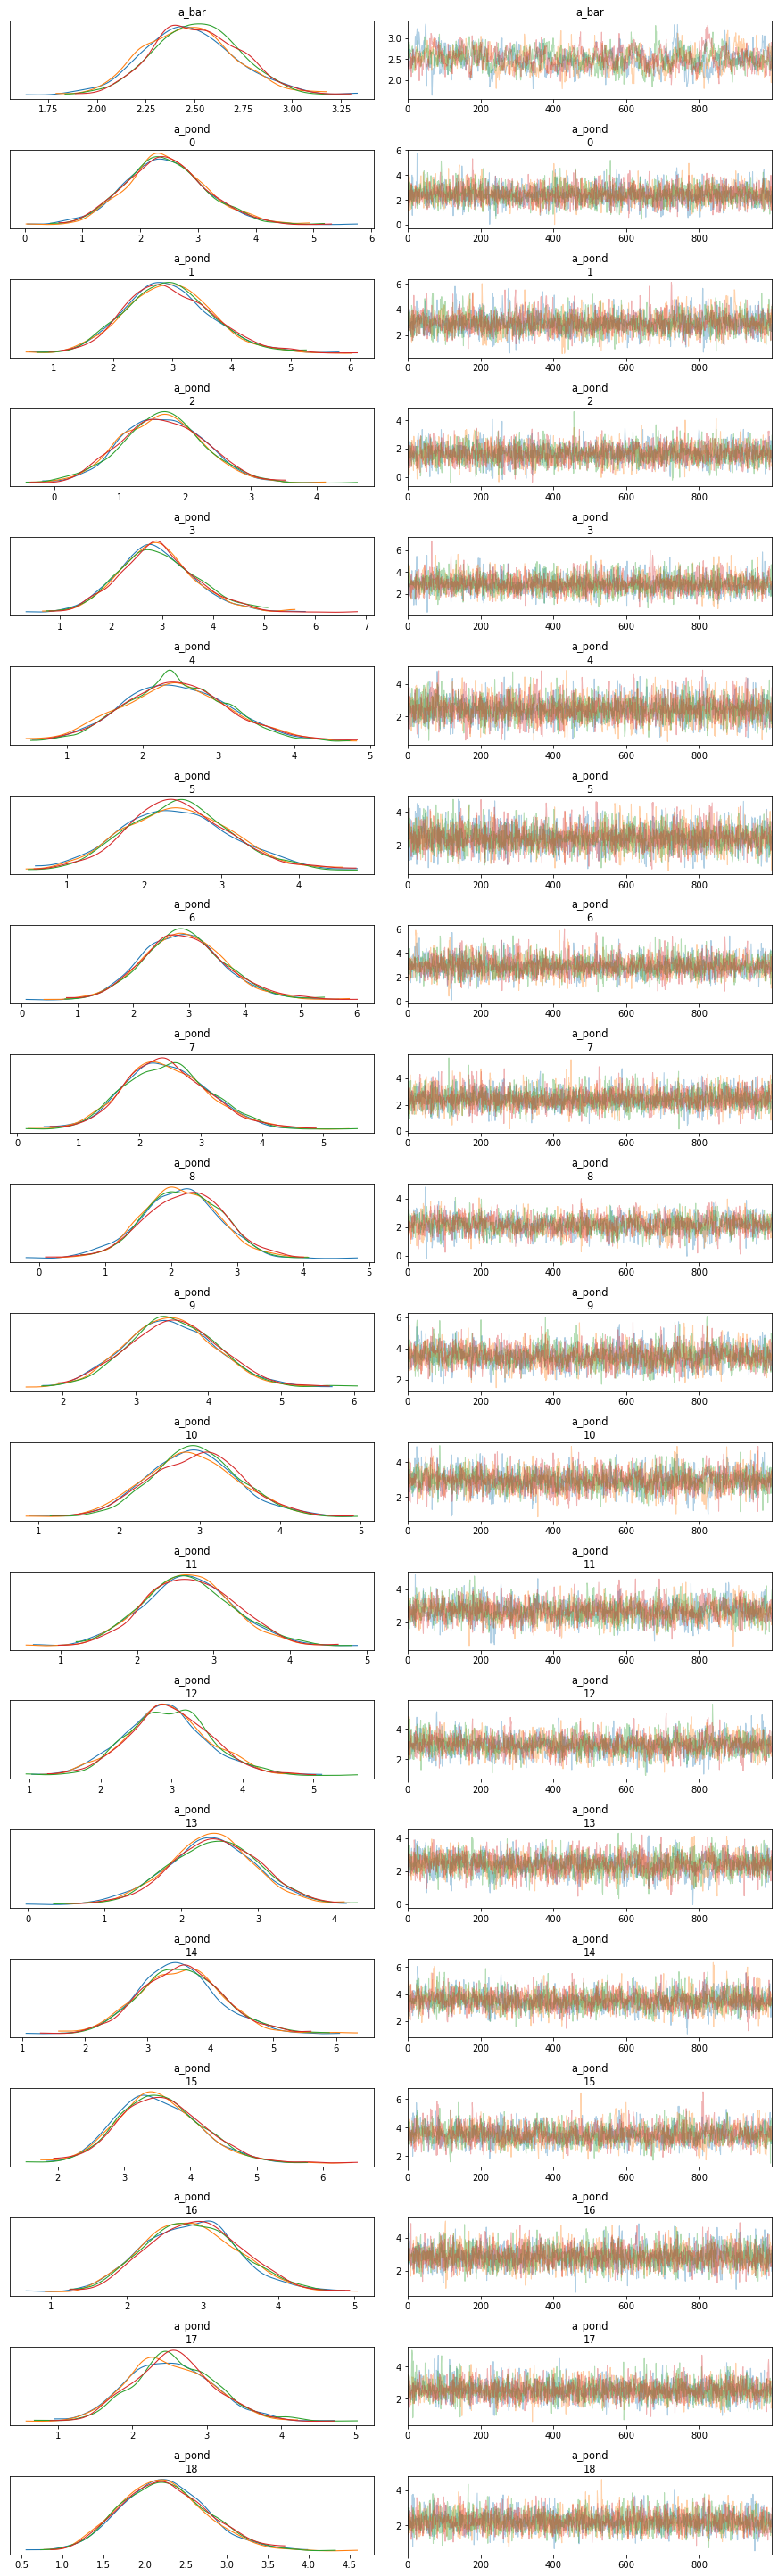

In [8]:
az.plot_trace(m2_trace)

In [9]:
az.summary(m2_trace, kind='stats', round_to=2)

mean    sd  hdi_3%  hdi_97%
a_bar       2.49  0.23    2.08     2.93
a_pond[0]   2.45  0.69    1.22     3.80
a_pond[1]   2.95  0.76    1.56     4.38
a_pond[2]   1.66  0.63    0.56     2.89
a_pond[3]   2.91  0.76    1.48     4.31
a_pond[4]   2.45  0.69    1.16     3.74
a_pond[5]   2.45  0.69    1.07     3.71
a_pond[6]   2.92  0.74    1.57     4.35
a_pond[7]   2.45  0.69    1.24     3.82
a_pond[8]   2.16  0.59    1.14     3.34
a_pond[9]   3.51  0.63    2.34     4.67
a_pond[10]  2.93  0.57    1.93     4.04
a_pond[11]  2.67  0.58    1.58     3.76
a_pond[12]  2.95  0.58    1.90     4.11
a_pond[13]  2.42  0.58    1.40     3.58
a_pond[14]  3.53  0.66    2.28     4.75
a_pond[15]  3.53  0.63    2.43     4.73
a_pond[16]  2.87  0.62    1.73     4.01
a_pond[17]  2.54  0.57    1.56     3.66
a_pond[18]  2.24  0.52    1.29     3.20
a_pond[19]  3.26  0.69    2.01     4.56
a_pond[20]  2.55  0.58    1.49     3.64
a_pond[21]  2.55  0.57    1.52     3.66
a_pond[22]  2.55  0.55    1.46     3.55
a_pond[23]  2.00  0.51    1.08     2.97
a_pond[24]  1.49  0.48    0.58     2.38
a_pond[25]  2.46  0.46    1.56     3.29
a_pond[26]  1.17  0.51    0.22     2.15
a_pond[27]  1.92  0.46    1.06     2.77
a_pond[28]  2.45  0.46    1.57     3.27
a_pond[29]  3.45  0.48    2.55     4.34
a_pond[30]  1.79  0.49    0.83     2.64
a_pond[31]  2.05  0.47    1.22     2.99
a_pond[32]  3.05  0.61    1.94     4.21
a_pond[33]  2.74  0.55    1.70     3.75
a_pond[34]  2.74  0.54    1.75     3.81
a_pond[35]  2.24  0.48    1.36     3.15
a_pond[36]  2.24  0.46    1.41     3.11
a_pond[37]  3.40  0.66    2.25     4.69
a_pond[38]  2.77  0.57    1.71     3.81
a_pond[39]  2.48  0.51    1.56     3.42
a_pond[40]  0.84  0.50   -0.15     1.71
a_pond[41]  1.83  0.44    0.97     2.64
a_pond[42]  1.93  0.43    1.19     2.80
a_pond[43]  2.03  0.44    1.24     2.88
a_pond[44]  2.84  0.43    2.07     3.65
a_pond[45]  1.83  0.44    1.02     2.68
a_pond[46]  3.94  0.48    3.03     4.85
a_pond[47]  2.34  0.43    1.54     3.14
b_pred     -2.37  0.30   -2.93    -1.81
sigma_a     0.83  0.15    0.56     1.11

## Model with ponds + size predictors

In [10]:
with pm.Model() as m3:
    a_bar = pm.Normal('a_bar', 0, 1.5)
    sigma_a = pm.Exponential('sigma_a', 1)
    a_pond = pm.Normal('a_pond', a_bar, sigma_a, shape=len(df.pond))
    
    b_pred = pm.Normal('b_pred', 0, 0.5, shape=len(df.pred_id.unique()))
    
    p = pm.math.invlogit(a_pond[df.pond] + b_pred[df.pred_id])
    
    Si = pm.Binomial('Si', n=df.density, p=p, observed=df.surv)
    
    m3_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b_pred, a_pond, sigma_a, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.
The number of effective samples is smaller than 10% for some parameters.


/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/plots/traceplot.py:191: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (52), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'a_bar'}>,
        <AxesSubplot:title={'center':'a_bar'}>],
       [<AxesSubplot:title={'center':'a_pond\n0'}>,
        <AxesSubplot:title={'center':'a_pond\n0'}>],
       [<AxesSubplot:title={'center':'a_pond\n1'}>,
        <AxesSubplot:title={'center':'a_pond\n1'}>],
       [<AxesSubplot:title={'center':'a_pond\n2'}>,
        <AxesSubplot:title={'center':'a_pond\n2'}>],
       [<AxesSubplot:title={'center':'a_pond\n3'}>,
        <AxesSubplot:title={'center':'a_pond\n3'}>],
       [<AxesSubplot:title={'center':'a_pond\n4'}>,
        <AxesSubplot:title={'center':'a_pond\n4'}>],
       [<AxesSubplot:title={'center':'a_pond\n5'}>,
        <AxesSubplot:title={'center':'a_pond\n5'}>],
       [<AxesSubplot:title={'center':'a_pond\n6'}>,
        <AxesSubplot:title={'center':'a_pond\n6'}>],
       [<AxesSubplot:title={'center':'a_pond\n7'}>,
        <AxesSubplot:title={'center':'a_pond\n7'}>],
       [<AxesSubplot:title={'center':'a_pond\n8'}>,
        <Ax

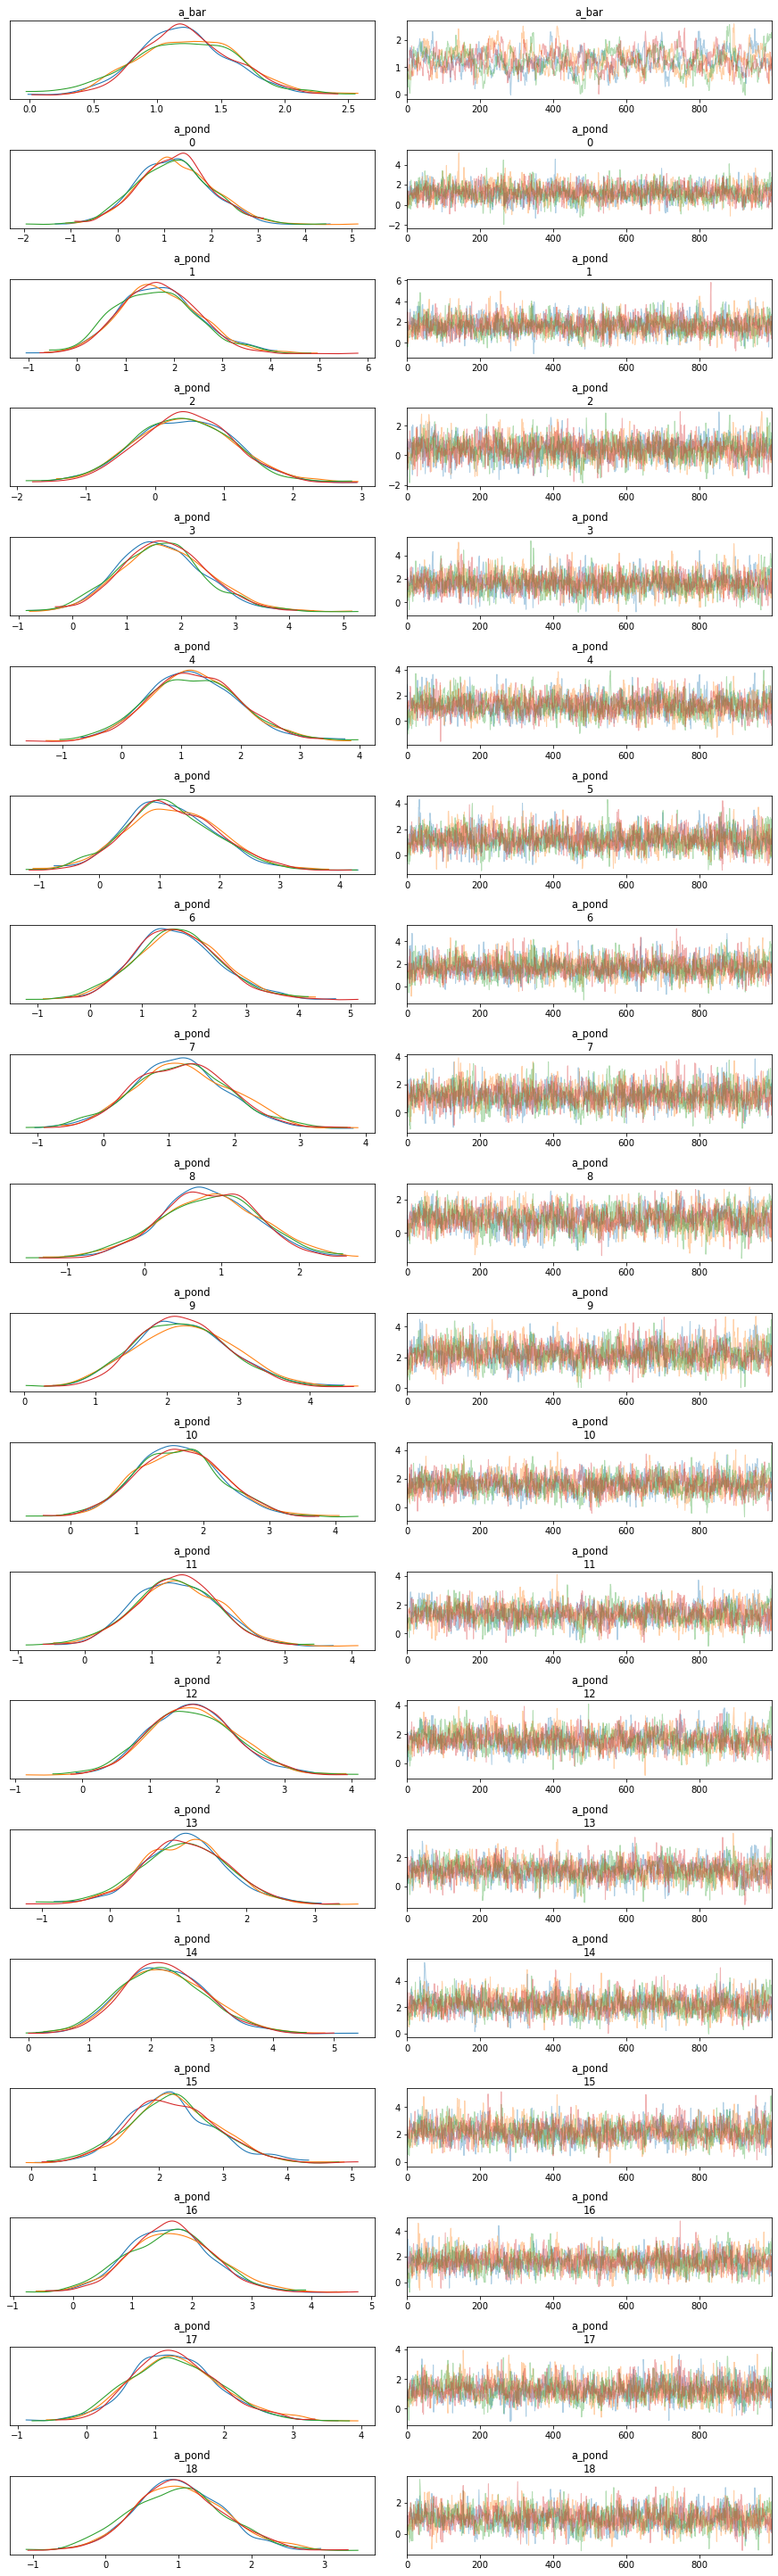

In [11]:
az.plot_trace(m3_trace)

## Model with ponds + predation + size predictors

In [12]:
with pm.Model() as m4:
    a_bar = pm.Normal('a_bar', 0, 1.5)
    sigma_a = pm.Exponential('sigma_a', 1)
    a_pond = pm.Normal('a_pond', 0, 1, shape=len(df.pond))
    
    sigma_b = pm.Exponential('sigma_b', 1)
    b_pred = pm.Normal('b_pred', 0, sigma_b, shape=len(df.pred_id.unique()))
    
    c_size = pm.Normal('c_size', 0, 0.5, shape=len(df.pred_id.unique()))
    
    p = pm.math.invlogit(a_bar + a_pond[df.pond]*sigma_a + b_pred[df.pred_id] + c_size[df.size_id])
    
    Si = pm.Binomial('Si', n=df.density, p=p, observed=df.surv)
    
    m4_trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [c_size, b_pred, sigma_b, a_pond, sigma_a, a_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 15 seconds.


/home/elisio/anaconda3/lib/python3.8/site-packages/arviz/plots/traceplot.py:191: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (55), generating only 20 plots
  warnings.warn(


array([[<AxesSubplot:title={'center':'a_bar'}>,
        <AxesSubplot:title={'center':'a_bar'}>],
       [<AxesSubplot:title={'center':'a_pond\n0'}>,
        <AxesSubplot:title={'center':'a_pond\n0'}>],
       [<AxesSubplot:title={'center':'a_pond\n1'}>,
        <AxesSubplot:title={'center':'a_pond\n1'}>],
       [<AxesSubplot:title={'center':'a_pond\n2'}>,
        <AxesSubplot:title={'center':'a_pond\n2'}>],
       [<AxesSubplot:title={'center':'a_pond\n3'}>,
        <AxesSubplot:title={'center':'a_pond\n3'}>],
       [<AxesSubplot:title={'center':'a_pond\n4'}>,
        <AxesSubplot:title={'center':'a_pond\n4'}>],
       [<AxesSubplot:title={'center':'a_pond\n5'}>,
        <AxesSubplot:title={'center':'a_pond\n5'}>],
       [<AxesSubplot:title={'center':'a_pond\n6'}>,
        <AxesSubplot:title={'center':'a_pond\n6'}>],
       [<AxesSubplot:title={'center':'a_pond\n7'}>,
        <AxesSubplot:title={'center':'a_pond\n7'}>],
       [<AxesSubplot:title={'center':'a_pond\n8'}>,
        <Ax

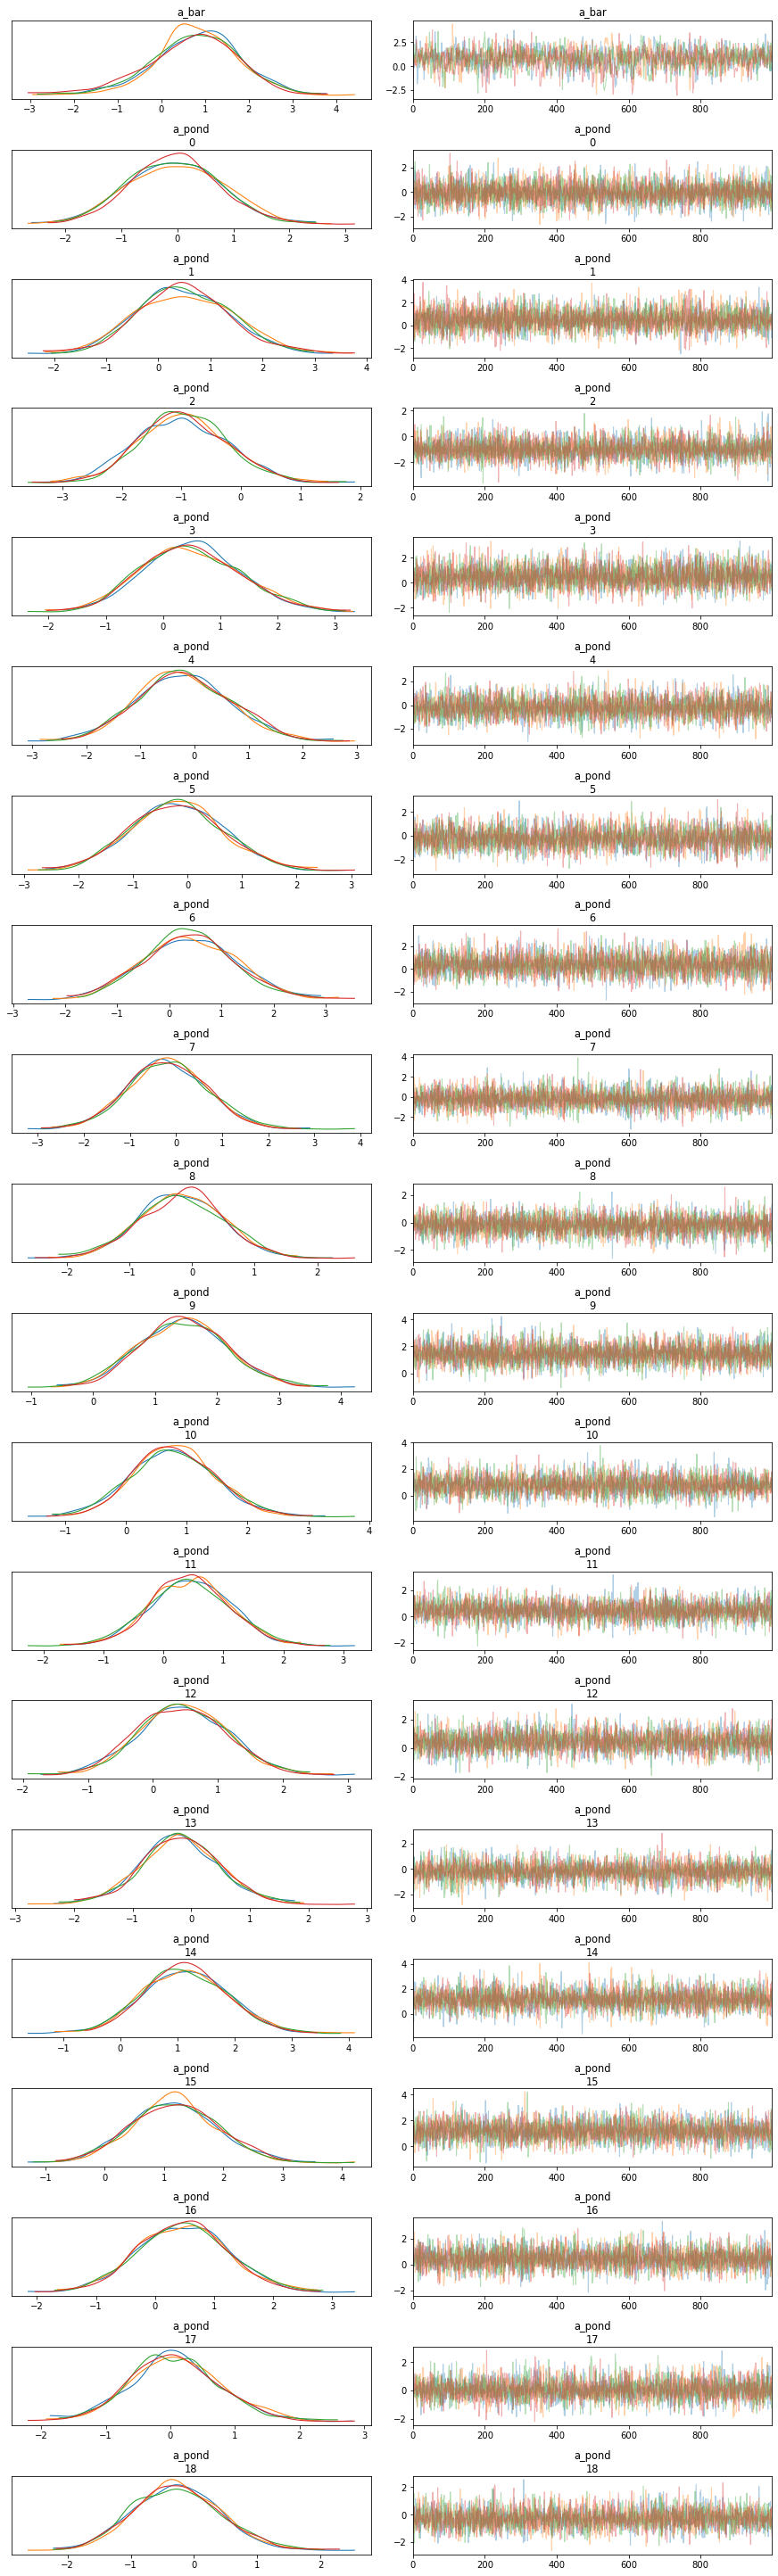

In [13]:
az.plot_trace(m4_trace)

---
---

In [14]:
%load_ext watermark
%watermark -iv -v -nuw

Last updated: Sun Apr 04 2021

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.19.0

arviz     : 0.10.0
numpy     : 1.19.1
pymc3     : 3.9.3
pandas    : 1.0.5
seaborn   : 0.11.0
matplotlib: 3.3.2
scipy     : 1.5.4
daft      : 0.1.0

Watermark: 2.1.0

